# Lets figure out GIS

## Todo

- [ ] Get property boundaries loaded
- [ ] Get planning layers loaded
- [ ] Get heritage overlays loaded
- [ ] Delete earlier notebook

# Scrapping

Here I'm testing different configurations for scrapping.

## Different APIs to test

- [NSW Spatial][portal-nsw-spatial] `https://portal.spatial.nsw.gov.au`
  - **NSW Property feature layer**: this is of interest because it has NSW property id which can be used to link against the value general stuff.
  - **NSW Lot feature layer**: This is interesting as it has lot numbers.
- [Environment NSW][portal-nsw-environment]

[portal-nsw-environment]: https://mapprod3.environment.nsw.gov.au/arcgis/rest/services/Planning/EPI_Primary_Planning_Layers/MapServer
[portal-nsw-spatial]: https://portal.spatial.nsw.gov.au/server/rest/services/NSW_Land_Parcel_Property_Theme/FeatureServer

## Request Times

- Querying NSW Address field
  - Filtering by `lastupdated` field
    - Jan 2023 to Jun 2024, 0h 3m 55s
    - Jan 2020 to Oct 2024, 0h 10m 39s 
    - Jan 2010 to Oct 2024, **4**h **16**m **29**s (`2410766` items)
      - Interestingly when I saw the finished result the last result was `April 2013`. At the time I thought that was the earlier it went back, but I think that must have been a timeframe with some of the most updates.
    - Feb 2013 to Apr 2013, **36**m **40**s (12 concurrent workers)
      - I checked this to see `April 2013` is really the last period
      - The first 2 months takes **2**m **27**s to run @ `25703` items
      - There must be a lot of stuff here
    - Jan 1990 to Feb 2013
      - `143600` items in it's at **35**m **24**s
      - got to `290100` items at **1**h **17**m **55**s and crashed on `2008-04-01`
    - Apr 2008 to May 2008
      - got to `249574` items at **1**h **1**m **4**s, still going
      - got to `422941` items at **1**h **53**m **42**s, then crashed

2024-09-24 12:01:10 #1583: 157122 items via @ 0h 1m 48s
https://portal.spatial.nsw.gov.au/server/rest/services/NSW_Land_Parcel_Property_Theme/FeatureServer/12
(1600/11097) 14% progress for lastupdate >= DATE '2021-11-1' AND lastupdate < DATE '2021-12-1'


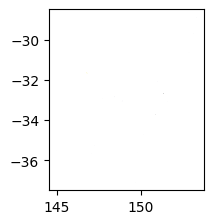

,RID,propid,principaladdresssiteoid,addressstringoid,propertytype,superlot,housenumber,address,principaladdresstype,createdate,startdate,enddate,lastupdate,shapeuuid,changetype,Shape__Length,Shape__Area,geometry
0,5955649,4392774,4547521,8566792,1,N,586,586 GLENBAWN ROAD SEGENHOE,1,1636152816000,1636153262000,32503680000000,1636153487345,a72019bf-0422-3b29-b618-4ad351677870,M,5046.384137,781081.606741,"POLYGON ((150.97076 -32.0917, 150.97107 -32.09..."


In [ ]:
from lib.tasks.gis_scrapper import run_in_notebook

await run_in_notebook()